In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as keras
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

df = pd.read_csv(R'C:\Users\Dell\Desktop\New folder (2)\Flipout\cleaned.csv')
print(df.shape)
df.head()

(18398, 54)


,time,y,x1,x2,x3,x4,x5,x7,x8,x9,...,x49,x50,x51,x52,x53,x54,x55,x56,x58,x60
0,1999-05-01 00:00:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,0.000732,-0.061114,-0.059966,...,10.210182,11.295155,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,0.033444,0.006076
1,1999-05-01 00:02:00,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,0.000732,-0.061114,-0.059966,...,12.534340,11.290761,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,0.033536,0.006083
2,1999-05-01 00:04:00,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,0.010803,-0.061114,-0.030057,...,18.582893,11.286366,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,0.033629,0.006090
3,1999-05-01 00:06:00,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,0.002075,-0.061114,-0.019986,...,17.719032,11.281972,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,0.033721,0.006097
4,1999-05-01 00:08:00,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,0.000732,-0.061114,-0.030057,...,16.855202,11.277577,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,0.033777,0.006105


In [145]:
x = df.iloc[:,2:]
Y = df.y.astype(int)
sd = StandardScaler()
df_new = pd.DataFrame(sd.fit_transform(x), columns=x.columns, index=x.index)
x_train, x_test, y_train, y_test = train_test_split(df_new,Y,train_size = 0.80, random_state = 42)
BATCH_SIZE = 64
TRAIN_COUNT = len(y_train)
TEST_COUNT = len(y_test)
BATCHES_PER_EPOCH = TRAIN_COUNT // BATCH_SIZE
TEST_BATCHES_PER_EPOCH = TEST_COUNT // BATCH_SIZE
INPUT_SIZE = np.shape(x_train)[1]

print('Train count:', TRAIN_COUNT, 'Test count:', TEST_COUNT)

Train count: 14718 Test count: 3680


### Input Datasets

In [28]:
def combined_dataset(features, labels):
    assert features.shape[0] == labels.shape[0]
    dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(features, axis=-1), labels))
    return dataset

# For training
def train_input_fn():
    dataset = combined_dataset(x_train, y_train)
    return dataset.shuffle(TEST_COUNT, reshuffle_each_iteration=True).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

# For evaluation and metrics
def eval_input_fn():
    dataset = combined_dataset(x_test, y_test)
    return dataset.repeat().batch(BATCH_SIZE).prefetch(1)

training_batches = train_input_fn()
training_iterator = tf.compat.v1.data.make_one_shot_iterator(training_batches)
heldout_iterator = tf.compat.v1.data.make_one_shot_iterator(eval_input_fn())

# Combine these into a feedable iterator that can switch between training
# and validation inputs.
handle = tf.compat.v1.placeholder(tf.string, shape=[])
feedable_iterator = tf.compat.v1.data.Iterator.from_string_handle(handle, tf.compat.v1.data.get_output_types(training_batches),
                                           tf.compat.v1.data.get_output_shapes(training_batches))
# feedable_iterator = tf.compat.v1.data.Iterator.from_string_handle(handle, training_batches.output_types, training_batches.output_shapes)
series, labels = feedable_iterator.get_next()


#### Bayesian CNN Model


Model consists of:
* An initial 1-D convolutional layer
* 5 repeated residual blocks (`same` padding)
* A fully-connected layer
* A linear layer with softmax output
* Flipout layers are used instead of standard layers

In [163]:
#  It is a scheduling technique designed to prevent posterior collapse among autoregressive VAEs.
# At the beginning of learning, the beta value is reduced to force the latent z to contain meaningful information,
# and the beta value is gradually increased to match the prior.
KL_ANNEALING = 30

MODEL_PATH = r'C:\Users\Dell\Desktop\New folder (2)\Flipout\model'

def kernel_prior(dtype, shape, name, trainable, add_variable_fn):
    return tfp.layers.default_multivariate_normal_fn(dtype, shape, name, trainable, add_variable_fn)

def conv_unit(unit, input_layer):
    s = '_' + str(unit)
    layer = tfp.layers.Convolution1DFlipout(name='Conv1' + s, filters=32, kernel_size=5, strides=1, padding='same', activation='relu', kernel_prior_fn=kernel_prior)(input_layer)
    layer = tfp.layers.Convolution1DFlipout(name='Conv2' + s, filters=32, kernel_size=5, strides=1, padding='same', activation=None, kernel_prior_fn=kernel_prior)(layer )
    layer = keras.Add(name='ResidualSum' + s)([layer, input_layer])
    layer = keras.Activation("relu", name='Act' + s)(layer)
    layer = keras.MaxPooling1D(name='MaxPool' + s, pool_size=2, strides=2)(layer)
    return layer

def model_fn(input_shape):
    time_series = tf.keras.layers.Input(shape=input_shape, dtype='float32')
    
    current_layer = tfp.layers.Convolution1DFlipout(filters=32, kernel_size=5, strides=1, kernel_prior_fn=kernel_prior)(time_series)

    for i in range(5):
        current_layer = conv_unit(i + 1, current_layer)

    current_layer = keras.Flatten()(current_layer)
    current_layer = tfp.layers.DenseFlipout(32, name='FC1', activation='relu', kernel_prior_fn=kernel_prior)(current_layer)
    logits = tfp.layers.DenseFlipout(2, name='Output', kernel_prior_fn=kernel_prior)(current_layer)
    
    model = tf.keras.Model(inputs=time_series, outputs=logits, name='bayes_cnn_model')
    return model
  
# Compute the negative Evidence Lower Bound (ELBO) loss
t = tf.compat.v1.Variable(0.0)

def loss_fn(labels, logits):
    labels_distribution = tfd.Categorical(logits=logits)

    # Perform KL annealing. The optimal number of annealing steps
    # depends on the dataset and architecture.
    kl_regularizer = t / (KL_ANNEALING * BATCHES_PER_EPOCH)

    # Compute the -ELBO as the loss. The kl term is annealed from 0 to 1 over
    # the epochs specified by the kl_annealing flag.
    log_likelihood = labels_distribution.log_prob(labels)
    neg_log_likelihood = -tf.reduce_mean(input_tensor=log_likelihood)
    kl = sum(model.losses) / len(x_train) * tf.minimum(1.0, kl_regularizer)
    return neg_log_likelihood + kl, kl, kl_regularizer, labels_distribution

model = model_fn([INPUT_SIZE,1])
model.summary()

Model: "bayes_cnn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 52, 1)]      0           []                               
                                                                                                  
 conv1d_flipout_31 (Conv1DFlipo  (None, 48, 32)      352         ['input_32[0][0]']               
 ut)                                                                                              
                                                                                                  
 Conv1_1 (Conv1DFlipout)        (None, 48, 32)       10272       ['conv1d_flipout_31[0][0]']      
                                                                                                  
 Conv2_1 (Conv1DFlipout)        (None, 48, 32)       10272       ['Conv1_1[0][0]']  

### Train model

In [164]:
INITIAL_LEARNING_RATE = 0.001
EPOCHS = 50

assert (EPOCHS > 0)

logits = model(series)
loss, kl, kl_reg, labels_distribution = loss_fn(labels, logits)

# Build metrics for evaluation. Predictions are formed from a single forward
# pass of the probabilistic layers. They are cheap but noisy
# predictions.
predictions = tf.argmax(input=logits, axis=1)
with tf.compat.v1.name_scope("train"):
    train_accuracy, train_accuracy_update_op = tf.compat.v1.metrics.accuracy(labels=labels, predictions=predictions)
    opt = tf.compat.v1.train.AdamOptimizer(INITIAL_LEARNING_RATE)
    train_op = opt.minimize(loss)
    update_step_op = tf.compat.v1.assign(t, t + 1)

with tf.compat.v1.name_scope("valid"):
    valid_accuracy, valid_accuracy_update_op = tf.compat.v1.metrics.accuracy(labels=labels, predictions=predictions)

init_op = tf.group(tf.compat.v1.global_variables_initializer(), tf.compat.v1.local_variables_initializer())

stream_vars_valid = [
    v for v in tf.compat.v1.local_variables() if "valid/" in v.name
]
reset_valid_op = tf.compat.v1.variables_initializer(stream_vars_valid)

with tf.compat.v1.Session() as sess:
    sess.run(init_op)

    # Run the training loop
    train_handle = sess.run(training_iterator.string_handle())
    heldout_handle = sess.run(heldout_iterator.string_handle())
    training_steps = EPOCHS * BATCHES_PER_EPOCH
    
    for step in range(training_steps):
        _ = sess.run([train_op, train_accuracy_update_op, update_step_op], feed_dict={handle: train_handle})

        # Manually print the frequency
        if step % (BATCHES_PER_EPOCH // 5) == 0:
            loss_value, accuracy_value, kl_value, kl_reg_value = sess.run([loss, train_accuracy, kl, kl_reg], feed_dict={handle: train_handle})
            print("   Loss: {:.3f} Accuracy: {:.3f} KL: {:.3f} KL-reg: {:.3f}".format(loss_value, accuracy_value, kl_value, kl_reg_value))

        if (step + 1) % BATCHES_PER_EPOCH == 0:
            # Calculate validation accuracy
            for _ in range(TEST_BATCHES_PER_EPOCH):
                sess.run(valid_accuracy_update_op, feed_dict={handle: heldout_handle})
            
            valid_value = sess.run(valid_accuracy, feed_dict={handle: heldout_handle})
            print("Epoch: {:>3d} Validation Accuracy: {:.3f}".format((step + 1) // BATCHES_PER_EPOCH, valid_value))

            sess.run(reset_valid_op)
            
    model.save_weights(MODEL_PATH)

   Loss: 0.416 Accuracy: 0.500 KL: 0.003 KL-reg: 0.000
   Loss: 0.129 Accuracy: 0.979 KL: 0.121 KL-reg: 0.007
   Loss: 0.251 Accuracy: 0.987 KL: 0.238 KL-reg: 0.013
   Loss: 0.376 Accuracy: 0.988 KL: 0.355 KL-reg: 0.020
   Loss: 0.481 Accuracy: 0.990 KL: 0.471 KL-reg: 0.026
   Loss: 0.896 Accuracy: 0.990 KL: 0.586 KL-reg: 0.033
Epoch:   1 Validation Accuracy: 0.994
   Loss: 0.708 Accuracy: 0.991 KL: 0.700 KL-reg: 0.039
   Loss: 0.817 Accuracy: 0.991 KL: 0.813 KL-reg: 0.046
   Loss: 0.936 Accuracy: 0.991 KL: 0.925 KL-reg: 0.052
   Loss: 1.114 Accuracy: 0.991 KL: 1.035 KL-reg: 0.059
   Loss: 1.151 Accuracy: 0.992 KL: 1.143 KL-reg: 0.066
Epoch:   2 Validation Accuracy: 0.994
   Loss: 1.254 Accuracy: 0.992 KL: 1.249 KL-reg: 0.072
   Loss: 1.362 Accuracy: 0.992 KL: 1.353 KL-reg: 0.079
   Loss: 1.462 Accuracy: 0.992 KL: 1.456 KL-reg: 0.085
   Loss: 1.648 Accuracy: 0.992 KL: 1.556 KL-reg: 0.092
   Loss: 1.722 Accuracy: 0.992 KL: 1.655 KL-reg: 0.098
Epoch:   3 Validation Accuracy: 0.994
   Los

### Evaluate model

In [165]:
NUM_MONTE_CARLO = 20

model.load_weights(MODEL_PATH)

mc_counts = np.zeros((TEST_COUNT, 2))
x = np.expand_dims(x_test, -1)
sample_index = np.arange(TEST_COUNT)

for i in range(NUM_MONTE_CARLO):
    y_pred = np.argmax(model.predict(x), axis=1)
    mc_counts[sample_index, y_pred] += 1
    
y_pred = np.argmax(mc_counts, axis=1)
y_prob = mc_counts[sample_index, y_pred] / NUM_MONTE_CARLO

y_prob_correct = y_prob[y_pred == y_test]
y_prob_mis = y_prob[y_pred != y_test]

C:\Users\Dell\Anaconda\envs\graphAD\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


### Check probability estimates

### Compute metrics

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3658
           1       0.00      0.00      0.00        22

    accuracy                           0.99      3680
   macro avg       0.50      0.50      0.50      3680
weighted avg       0.99      0.99      0.99      3680



C:\Users\Dell\Anaconda\envs\graphAD\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\Anaconda\envs\graphAD\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\Anaconda\envs\graphAD\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

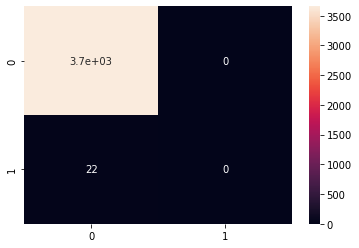

In [166]:
import sklearn.metrics as skm
import seaborn

# Classification report
report = skm.classification_report(y_test, y_pred)
print(report)

# Confusion matrix
cm = skm.confusion_matrix(y_test, y_pred)
seaborn.heatmap(cm, annot=True)